In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.optimize import curve_fit

In [2]:
volume_drop = 84e-15 #drop volume (m3)
spot_size = 17.5e-6 #spot size on cantilever (m)
surf_tens = 69.7e-3 #surface tension (N/m)
defect_radius = 220e-9 #radius of defect

# energy_nodefect = 8.54846 #simulated drop energy without defect
s = ((3*volume_drop)/(4*np.pi))**(1/3)
# defect_radius/s

In [3]:
# data_90 = pd.read_csv("data/results_azimuthangle0_hemisph.txt", delimiter='\t')
# data_90['Azimuthal angle'] = 0
# # data_90['defect_disp'] = (data_90['defect_posy'] -1.28992)/np.cos(0*np.pi/180) #CHECK
# zero_cross = data_90['defect_disp'].iloc[np.argmin(abs(data_90['force_laty_sum']))]
# data_90['defect_disp_shifted'] = data_90['defect_disp'] - zero_cross
# zero_eng = data_90['total_energy'].iloc[np.argmin(abs(data_90['force_laty_sum']))]
# data_90['energy_shifted'] = data_90['total_energy'] - zero_eng


# data_45 = pd.read_csv("data/results_azimuthangle60_hemisph.txt", delimiter='\t')
# data_45['Azimuthal angle'] = 30
# # data_45['defect_disp'] = (data_45['defect_posy'] -1.28992)/np.cos(30*np.pi/180) #CHECK
# zero_cross = data_45['defect_disp'].iloc[np.argmin(abs(data_45['force_laty_sum']))]
# data_45['defect_disp_shifted'] = data_45['defect_disp'] - zero_cross
# zero_eng = data_45['total_energy'].iloc[np.argmin(abs(data_45['force_laty_sum']))]
# data_45['energy_shifted'] = data_45['total_energy'] - zero_eng

file_list = [f'data/hemisphere_v7/results_azimuthang{i}.txt' for i in [0,30,45,60]]
# file_list = ['data/hemisphere_v5/results_azimuthang0.txt', 'data/hemisphere_v5/results_azimuthang0_contactang114.txt',
            # 'data/hemisphere_v5/results_azimuthang0_contactangdef10.txt']
data_list = []
for file_i in file_list:
    data_i = pd.read_csv(file_i, delimiter='\t')
    ind_start = np.argmin(abs(data_i['defect_disp']-(-data_i['defect_size']/2)))
    # ind_end = np.argmin(abs(data_i['defect_pos_angle_cent']-35))
    ind_end = np.argmin(data_i['force_laty_sum'])
    # print(disp_start, disp_end)
    # zero_cross = data_i['defect_disp'].iloc[np.argmin(abs(data_i['force_laty_sum']))]
    data_i['defect_disp_shifted'] = data_i['defect_disp'] - data_i['defect_disp'].iloc[ind_start]
    # zero_eng = data_i['total_energy'].iloc[np.argmin(abs(data_i['force_laty_sum']))]
    data_i['energy_shifted'] = data_i['total_energy'] - data_i['total_energy'].iloc[ind_start]

    data_i['defect_disp_end'] = data_i['defect_disp_shifted'].iloc[ind_end]
    data_i['force_latx_clean'] = data_i['force_latx_sum']
    # data_i.iloc[:ind_start, -1] = 0
    # data_i.iloc[ind_end+1:, -1] = 0
    data_i['force_laty_clean'] = data_i['force_laty_sum']
    # data_i.iloc[:ind_start, -1] = 0
    # data_i.iloc[ind_end+1:, -1] = 0
    data_i['force_norm_clean'] = data_i['force_norm_sum']
    # data_i.iloc[:ind_start, -1] = 0
    # data_i.iloc[ind_end+1:, -1] = 0
    data_i['energy_shifted_clean'] = data_i['energy_shifted']
    # data_i.iloc[:ind_start, -1] = 0
    # data_i.iloc[ind_end+1:, -1] = 0
    data_list.append(data_i)

data_all = pd.concat(data_list)

#convert to real units
data_all['Distance (um)'] = data_all['defect_disp_shifted']*s/1e-6 #um
data_all['Lateral force X (nN)'] = data_all['force_latx_clean']*surf_tens*s/1e-9 #nN
data_all['Lateral force Y (nN)'] = -data_all['force_laty_clean']*surf_tens*s/1e-9 #nN
data_all['Normal force (nN)'] = data_all['force_norm_clean']*surf_tens*s/1e-9 #nN
data_all['Energy (fJ)'] = (data_all['energy_shifted_clean'])*surf_tens*s*s/1e-15 #fJ
data_all['Energy full (fJ)'] = (data_all['energy_shifted'])*surf_tens*s*s/1e-15 #fJ

data_filt = data_all#.query("`defect_pos_angle` >  30").reset_index()
data_filt.rename(columns={"Distance (um)": "Distance (µm)", 
                          "azimuthal_angle": "Azimuthal angle"}, inplace=True)
# data_filt['legend'] = 'CA_def=' + data_filt['defect_angle'].apply(str) + ', CA_sub=' + data_filt['bottom_angle'].apply(str)

In [8]:
data_filt.to_excel('data/hemisphere_v7/simulation_results.xlsx')

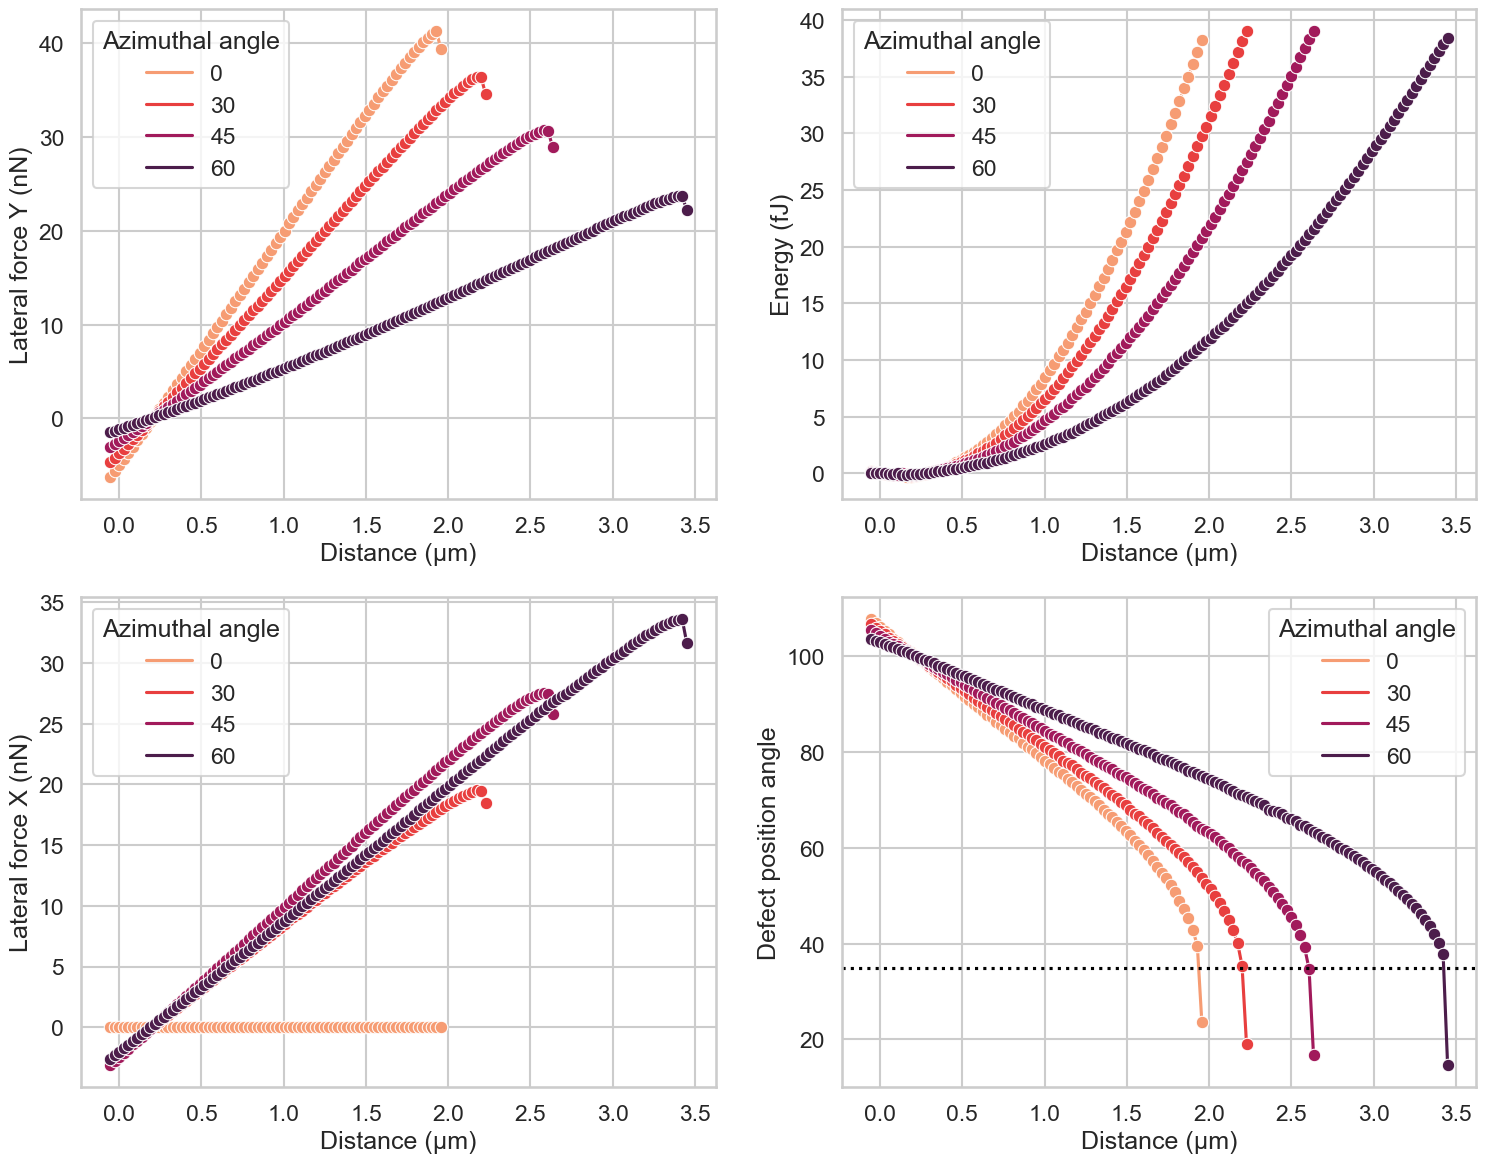

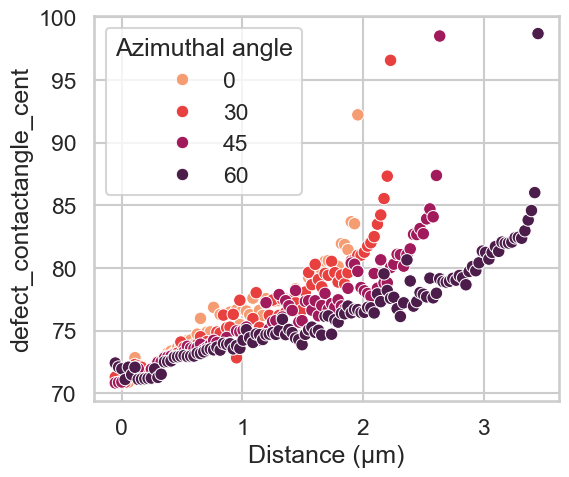

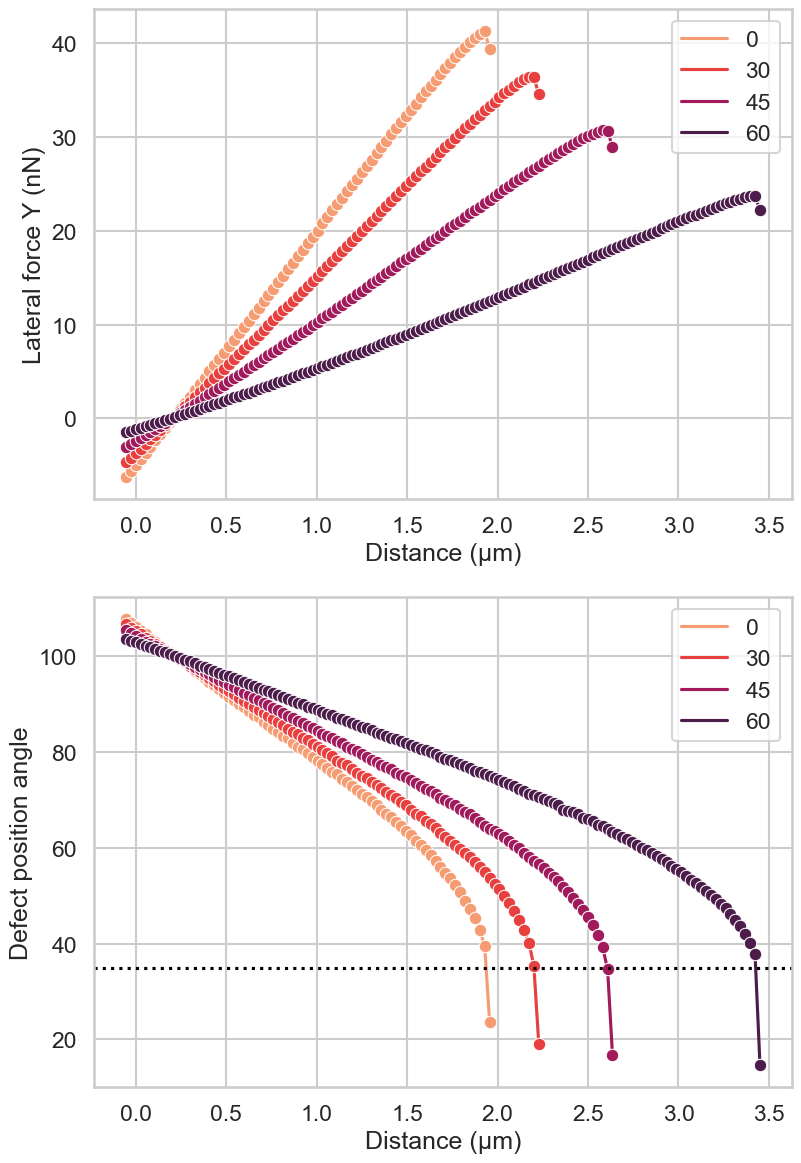

In [6]:
sns.set_context("talk")
sns.set_style("whitegrid")
cat_var = 'Azimuthal angle' #'Azimuthal angle', 'bottom_angle', 'legend'
data_filt[cat_var] = data_filt[cat_var].astype('category')
color_palette = sns.color_palette("rocket_r", n_colors=4)
fig1, ax1 = plt.subplots(2,2, figsize=(18,14))
fig2, ax2 = plt.subplots(1,1, figsize=(6,5))
sns.lineplot(data=data_filt, x='Distance (µm)', y='Lateral force Y (nN)', hue=cat_var, ax=ax1[0][0], 
             palette=color_palette, linestyle="-")
sns.lineplot(data=data_filt, x='Distance (µm)', y='Lateral force X (nN)', hue=cat_var, ax=ax1[1][0], 
             palette=color_palette, linestyle="-")
sns.lineplot(data=data_filt, x='Distance (µm)', y='Energy (fJ)', hue=cat_var, ax=ax1[0][1], 
             palette=color_palette, linestyle="-")
sns.lineplot(data=data_filt, x='Distance (µm)', y='defect_pos_angle_cent', hue=cat_var, ax=ax1[1][1], 
             palette=color_palette, linestyle="-")
ax1[1][1].set_ylabel('Defect position angle')
# Add markers to each line
for ax_i in ax1.flatten():
    for line in ax_i.lines:
        line.set_marker("o")  # Set the desired marker style
ax1[1][1].axhline(35, linestyle=':', color='black')
# sns.scatterplot(data=data_filt, x='Distance (µm)', y='defect_pos_angle_cent', hue='Azimuthal angle', ax=ax2, palette=color_palette)
# ax2.ylabel('Defect position angle')
# ax2.axhline(35, linestyle=':', color='black')
# plt.show()
sns.scatterplot(data=data_filt, x='Distance (µm)', y='defect_contactangle_cent', hue=cat_var, ax=ax2, palette=color_palette)
plt.show()

fig1.savefig('data/hemisphere_v7/simulation_plot_forces.png', dpi=300)

color_palette = sns.color_palette("rocket_r", n_colors=4)
fig3, ax3 = plt.subplots(2,1, figsize=(9,14))
sns.lineplot(data=data_filt, x='Distance (µm)', y='Lateral force Y (nN)', hue=cat_var, ax=ax3[0], 
             palette=color_palette, linestyle="-")
sns.lineplot(data=data_filt, x='Distance (µm)', y='defect_pos_angle_cent', hue=cat_var, ax=ax3[1], 
             palette=color_palette, linestyle="-")


for ax_i in ax3.flatten():
    ax_i.legend() #removes legend title
    for line in ax_i.lines:
        line.set_marker("o")  # Set the desired marker style

ax3[1].axhline(35, linestyle=':', color='black')
ax3[1].set_ylabel('Defect position angle')
plt.show()
# fig3.savefig('data/hemisphere_v6_CAs114_CAd70/simulation_plot_CAvaried.png', dpi=300)

Fitted A: 42.54217539753623, 47.91311341644004


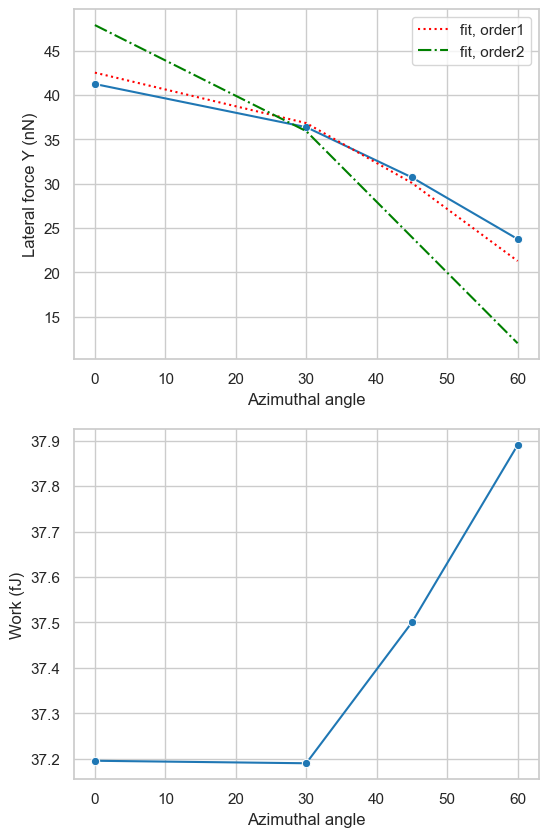

In [7]:
sns.set_context("notebook")
# distance_list = data_filt['defect_disp'].unique()
# print(distance_list)
# distance_values = [0.08, 0.1, 0.12]

# Filter the data for multiple values
# data_filt2 = data_filt[np.any([np.isclose(data_filt['defect_disp'], val) for val in distance_values], axis=0)]
data_filt2 = data_filt[data_filt['defect_disp_shifted']==data_filt['defect_disp_end']]
# data_filt2 = data_filt[np.isclose(data_filt['defect_disp'], 0.08)]

fig3, ax3 = plt.subplots(2,1, figsize=(6,10))
sns.lineplot(data=data_filt2, x='Azimuthal angle', y='Lateral force Y (nN)', ax=ax3[0], linestyle="-", legend=True)
sns.lineplot(data=data_filt2, x='Azimuthal angle', y='Energy (fJ)', ax=ax3[1], linestyle="-", legend=False)
# Add markers to each line
for ax_i in ax3:
    for line in ax_i.lines:
        line.set_marker("o")  # Set the desired marker style

# data_filt2['Distance (µm)']
# Format legend labels to 2 decimal points
# for text in ax3[0].legend_.texts:
#     text.set_text(f"{float(text.get_text()):.2f}")

#fit data
# Define the model function
def model(x, A):
    return A * np.cos(x*np.pi/180)**1

def model2(x, A):
    return A * np.cos(x*np.pi/180)**2

x_data = data_filt2['Azimuthal angle'].to_numpy()
y_data = data_filt2['Lateral force Y (nN)'].to_numpy()
# Perform the curve fitting
popt, pcov = curve_fit(model, x_data, y_data, p0=[1.0])  # initial guess for A
popt2, pcov2 = curve_fit(model2, x_data, y_data, p0=[1.0])  # initial guess for A

# Extract fitted parameter
fitted_A = popt[0]
fitted_A2 = popt2[0]
print(f"Fitted A: {fitted_A}, {fitted_A2}")

# Plot the data and the fit
# plt.scatter(x_data, y_data, label='data', color='blue')
ax3[0].plot(x_data, model(x_data, fitted_A), label='fit, order1', color='red', linestyle=':')
ax3[0].plot(x_data, model2(x_data, fitted_A2), label='fit, order2', color='green', linestyle='-.')

# ax3[0].set_ylabel('Lateral force Y (nN)')
ax3[1].set_ylabel('Work (fJ)')
ax3[0].legend()

# plt.gcf().savefig('data/hemisphere_v6_CAs114_CAd70/simulation_fit.png', dpi=300)
# plt.show()


plt.show()
data_filt2
fig3.savefig('data/hemisphere_v7/simulation_plot_forcevsangle.png', dpi=300)

Fitted A: 42.54217539753623, 47.91311341644004


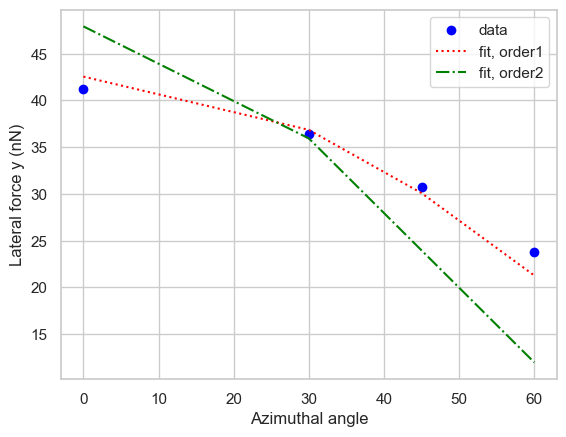

In [14]:
from scipy.optimize import curve_fit

# Example data
# x_data = np.linspace(0, 2 * np.pi, 50)  # x values
# true_A = 2.0  # true amplitude
# y_data = true_A * np.cos(x_data)**2 + np.random.normal(0, 0.1, len(x_data))  # y values with noise

# Define the model function
def model(x, A):
    return A * np.cos(x*np.pi/180)**1

def model2(x, A):
    return A * np.cos(x*np.pi/180)**2

x_data = data_filt2['Azimuthal angle'].to_numpy()
y_data = data_filt2['Lateral force y (nN)'].to_numpy()
# Perform the curve fitting
popt, pcov = curve_fit(model, x_data, y_data, p0=[1.0])  # initial guess for A
popt2, pcov2 = curve_fit(model2, x_data, y_data, p0=[1.0])  # initial guess for A

# Extract fitted parameter
fitted_A = popt[0]
fitted_A2 = popt2[0]
print(f"Fitted A: {fitted_A}, {fitted_A2}")

# Plot the data and the fit
plt.scatter(x_data, y_data, label='data', color='blue')
plt.plot(x_data, model(x_data, fitted_A), label='fit, order1', color='red', linestyle=':')
plt.plot(x_data, model2(x_data, fitted_A2), label='fit, order2', color='green', linestyle='-.')

plt.xlabel('Azimuthal angle')
plt.ylabel('Lateral force y (nN)')
plt.legend()

# plt.gcf().savefig('data/hemisphere_v6_CAs114_CAd70/simulation_fit.png', dpi=300)
plt.show()